## Notebook Purpose
1. Join the media csv file generated within with the predictions file to capture data about the predictions.
2. Show some statistics by the hour for predicted species counts.


## Data ETL and Cleaning

In [36]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read in data
preds_df = pd.read_csv('2025-06-28_predictions_with_url.csv')
media_df = pd.read_csv('../../output/media.csv')


In [4]:
# Take a look at data
print("------------------------- Preds: -------------------------")
display(preds_df.head(1))
print("------------------------- Media: -------------------------")
display(media_df.head(1))


------------------------- Preds: -------------------------


,mediaID,predicted_class,common_name,probability,top3,publicURL
0,002fe9a5dc3a1bf6b14298838bae6982,Branta_canadensis,Canada Goose,0.9101,"Canada Goose: 0.9101, Mallard: 0.0161, Beaver:...",https://urbanriverrangers.s3.amazonaws.com/ima...


------------------------- Media: -------------------------


,mediaID,deploymentID,captureMethod,timestamp,filePath,filePublic,fileName,fileMediatype,exifData,favorite,mediaComments
0,c112813a5f3b9cec26f95fad982b8d09,66e5dee8f8e217337ca907a5,NaN,2024-01-24T18:56:50Z,https://urbanriverrangers.s3.amazonaws.com/ima...,True,SYFW0001.JPG,image/jpeg,"{""Make"": ""TC"", ""Model"": ""XG2"", ""Software"": ""R2...",False,NaN


In [5]:
merged_df = pd.merge(preds_df, media_df, how='left', on='mediaID')
print(merged_df.columns)

Index(['mediaID', 'predicted_class', 'common_name', 'probability', 'top3',
       'publicURL', 'deploymentID', 'captureMethod', 'timestamp', 'filePath',
       'filePublic', 'fileName', 'fileMediatype', 'exifData', 'favorite',
       'mediaComments'],
      dtype='object')


In [6]:
selected_cols = [
    'mediaID', 'predicted_class', 'common_name', 'probability', 'publicURL', 'deploymentID', 'timestamp'
]

media_preds = merged_df[selected_cols]
media_preds.head()

,mediaID,predicted_class,common_name,probability,publicURL,deploymentID,timestamp
0,002fe9a5dc3a1bf6b14298838bae6982,Branta_canadensis,Canada Goose,0.9101,https://urbanriverrangers.s3.amazonaws.com/ima...,66e5dee8f8e217337ca907a5,2024-04-26T22:14:54Z
1,005c423247c6a4cd127cdabf8df3458c,Branta_canadensis,Canada Goose,0.9990,https://urbanriverrangers.s3.amazonaws.com/ima...,66e5dee8f8e217337ca907a5,2024-04-25T19:53:30Z
2,006d951cf93f27e70b3c5aa2190b1135,Branta_canadensis,Canada Goose,0.9916,https://urbanriverrangers.s3.amazonaws.com/ima...,66e5dee8f8e217337ca907a5,2024-04-22T05:46:48Z
3,00716c8d2c5bd8b735bfdb4cb9099519,Castor_canadensis,Beaver,0.3964,https://urbanriverrangers.s3.amazonaws.com/ima...,66e5dee8f8e217337ca907a5,2024-04-20T22:10:49Z
4,00bb8837f97b2266fcf1a6cebc90db40,Branta_canadensis,Canada Goose,0.8593,https://urbanriverrangers.s3.amazonaws.com/ima...,66e5dee8f8e217337ca907a5,2024-05-05T21:46:50Z


In [26]:
# Ensure timestamp is datetime and hour is extracted
media_preds.loc[:, 'timestamp'] = pd.to_datetime(media_preds['timestamp'])
media_preds.loc[:, 'hour'] = media_preds['timestamp'].dt.hour

# Group by species and hour, count occurrences
species_hour_counts = media_preds.groupby(['common_name', 'hour']).size().reset_index(name='count')

# Normalize counts for each species
species_hour_counts['norm_count'] = round(species_hour_counts.groupby('common_name')['count'].transform(lambda x: x / x.max()),3)

display(species_hour_counts.head())

,common_name,hour,count,norm_count
0,Beaver,0,62,0.705
1,Beaver,1,61,0.693
2,Beaver,2,50,0.568
3,Beaver,3,69,0.784
4,Beaver,4,45,0.511


## Visualizations

### Time Series

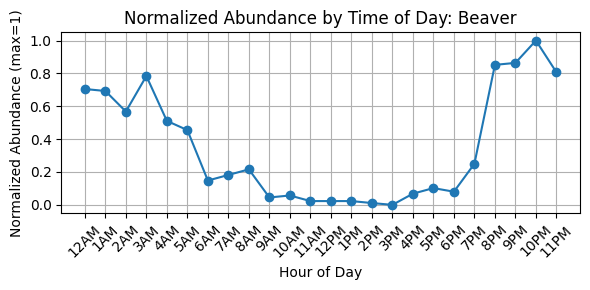

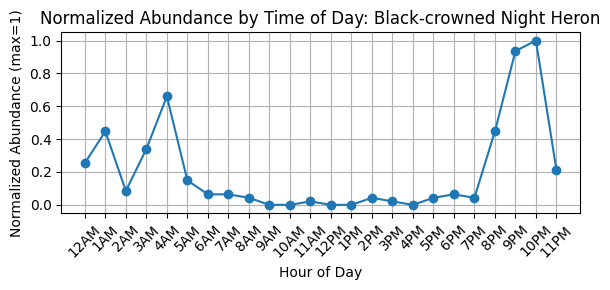

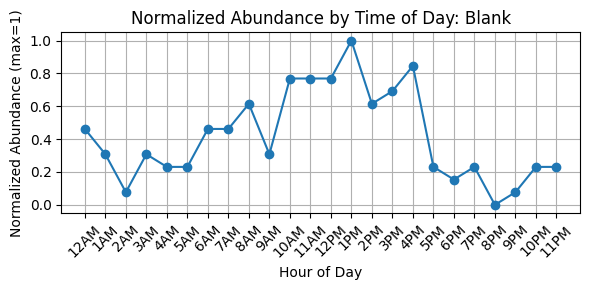

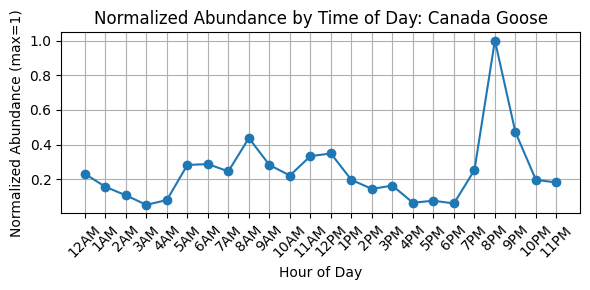

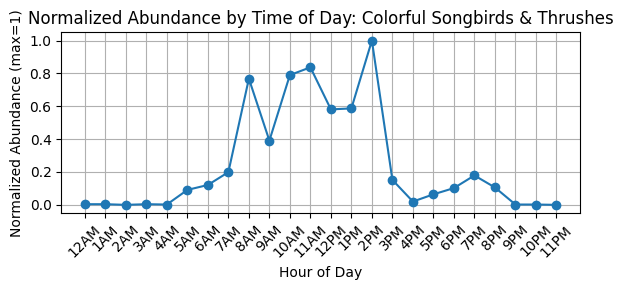

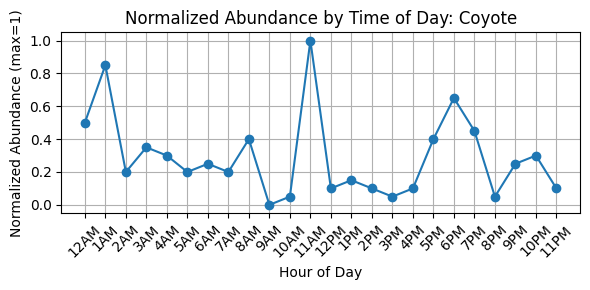

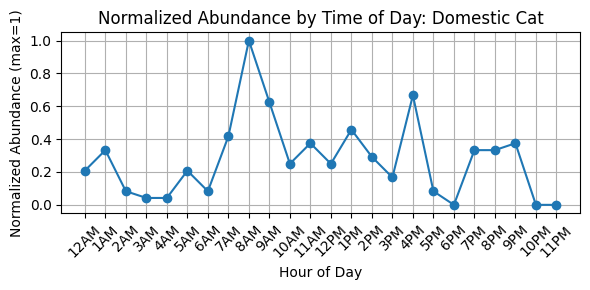

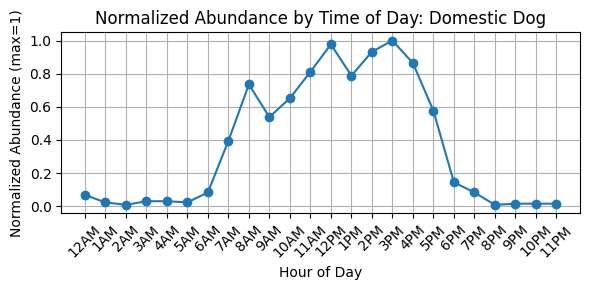

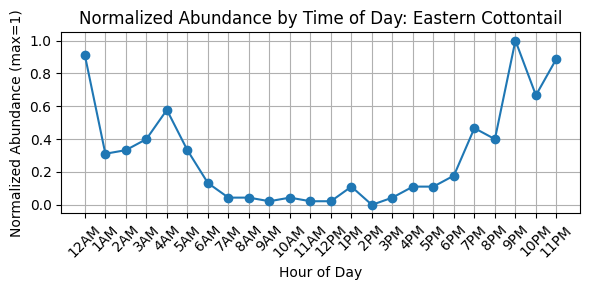

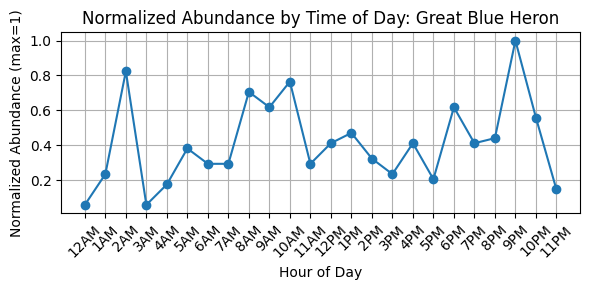

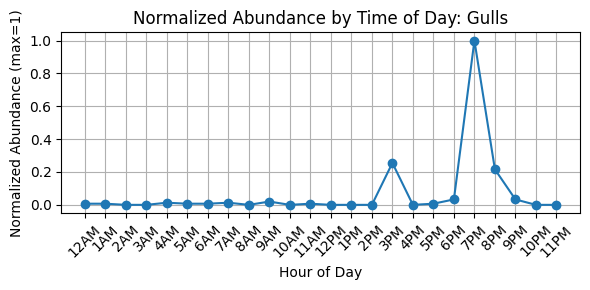

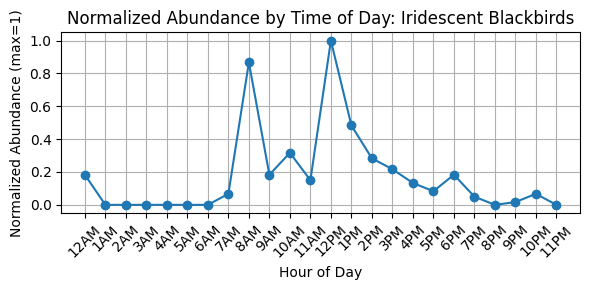

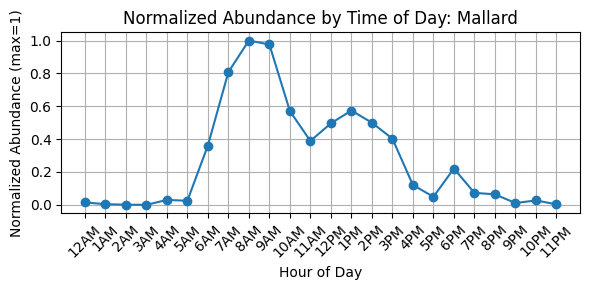

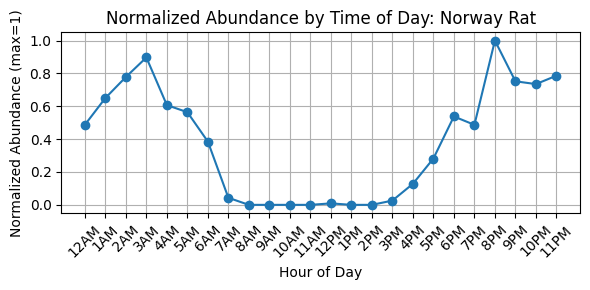

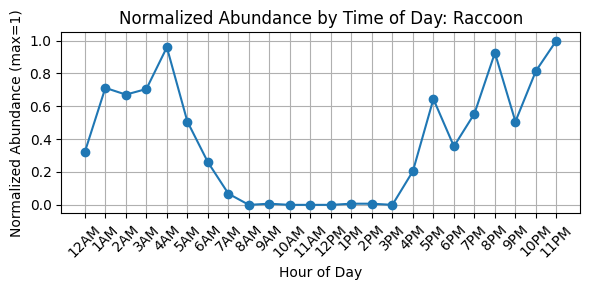

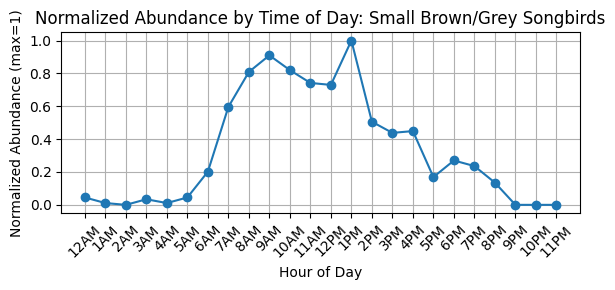

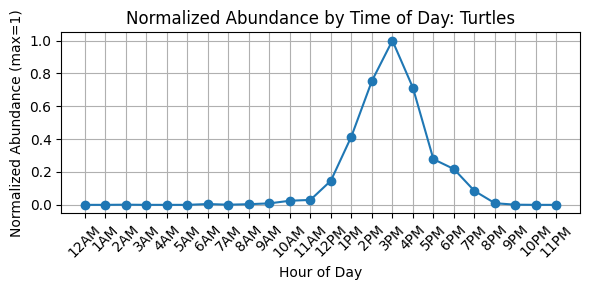

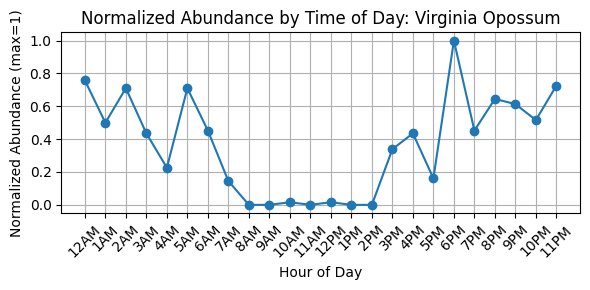

In [22]:
# Plot for each species
species_list = species_hour_counts['common_name'].unique()

hours = range(24)
hour_labels = [f"{h%12 if h%12 else 12}{'AM' if h < 12 else 'PM'}" for h in hours]

for species in species_list:
    data = species_hour_counts[species_hour_counts['common_name'] == species]
    # add 0s for missing data
    data = data.set_index('hour').reindex(hours, fill_value=0).reset_index()

    plt.figure(figsize=(6, 3))
    plt.plot(
        data['hour'],
        data['norm_count'],
        marker='o',
        color='tab:blue'
    )
    plt.xticks(hours, hour_labels, rotation=45)
    plt.xlabel('Hour of Day')
    plt.ylabel('Normalized Abundance (max=1)')
    plt.title(f'Normalized Abundance by Time of Day: {species}')
    plt.grid(True)
    plt.tight_layout()
    



### Radar Plots

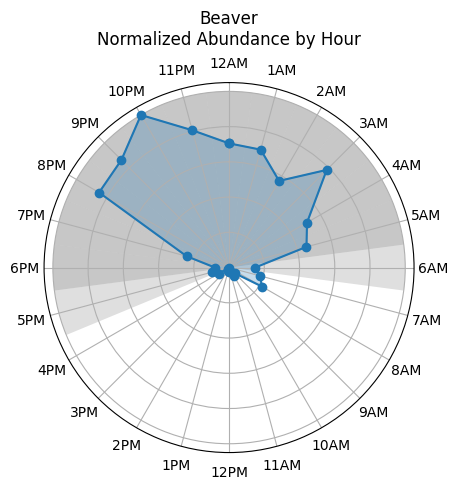

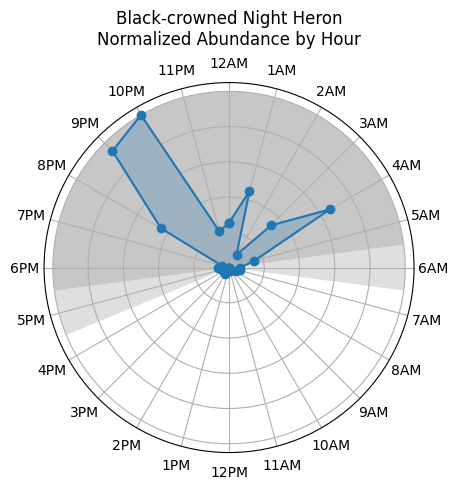

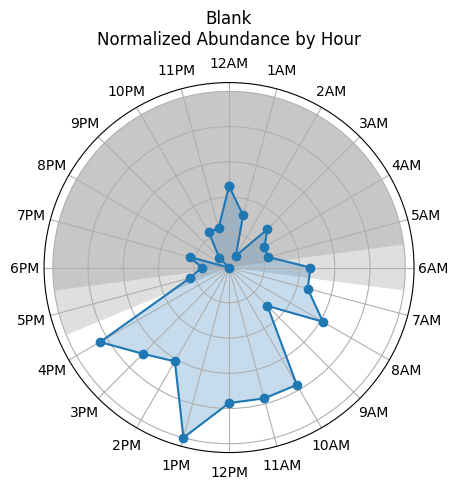

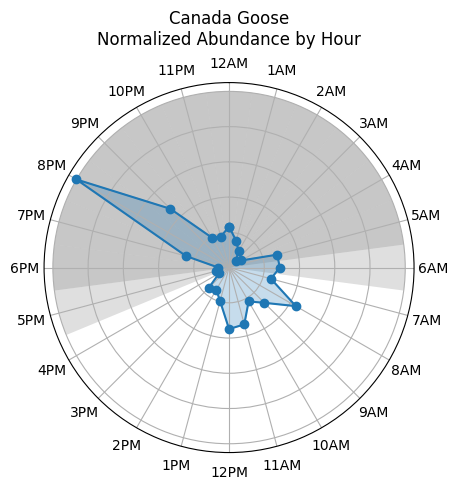

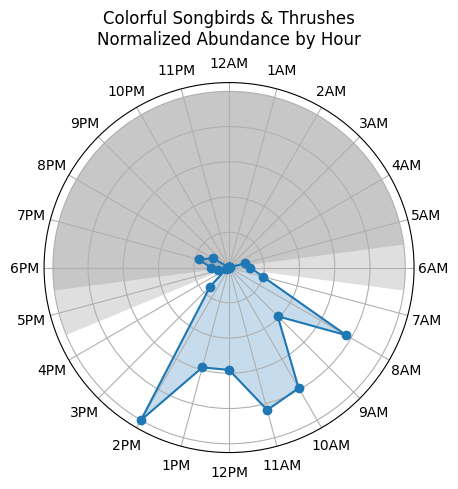

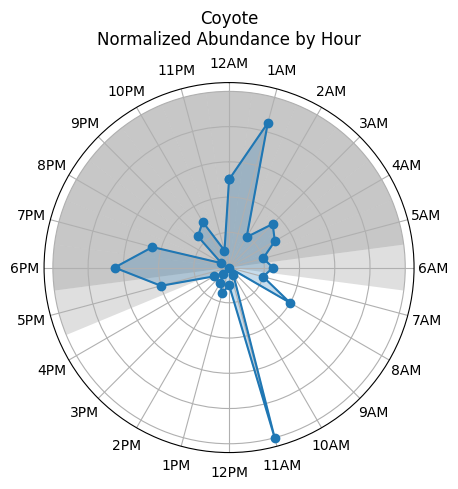

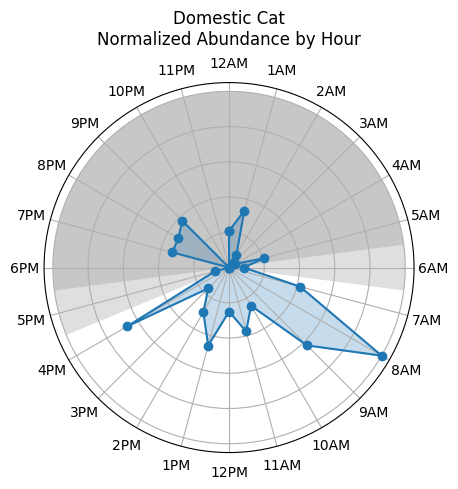

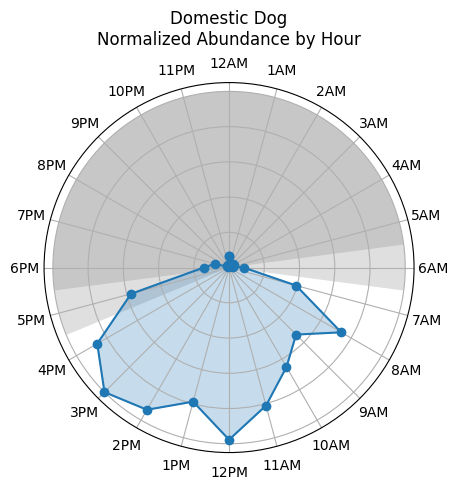

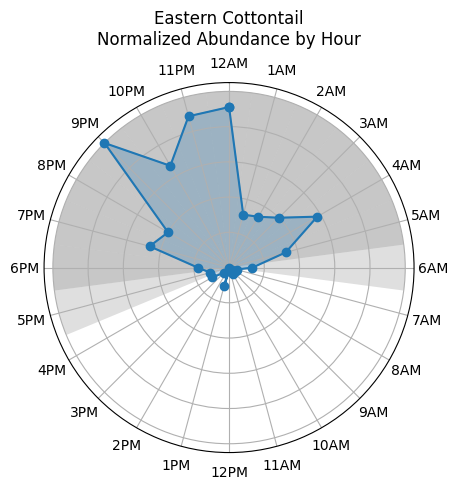

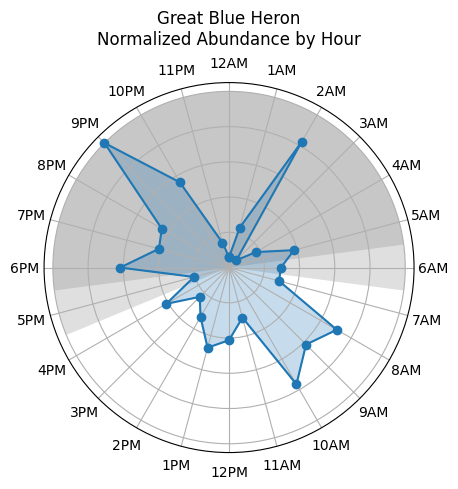

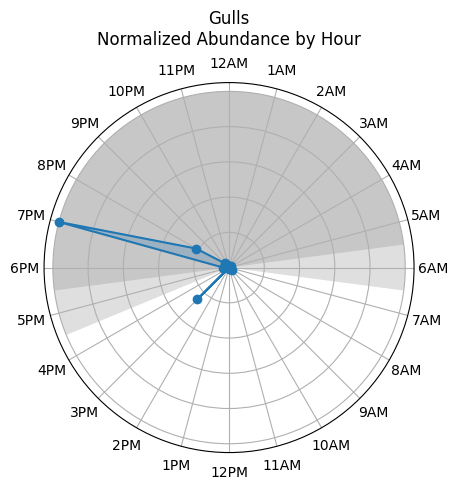

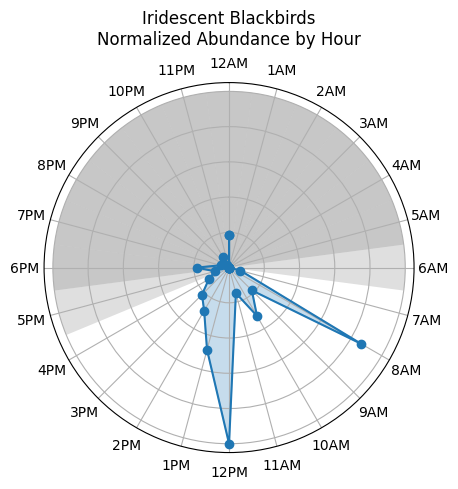

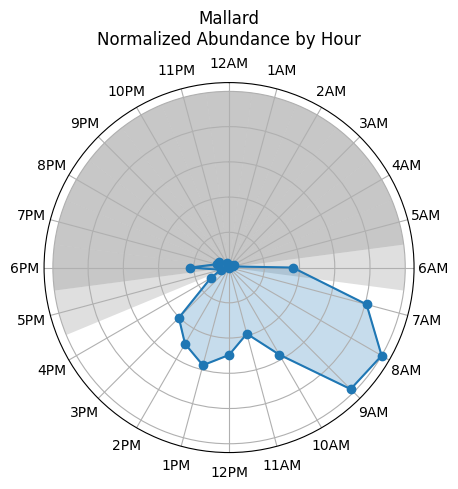

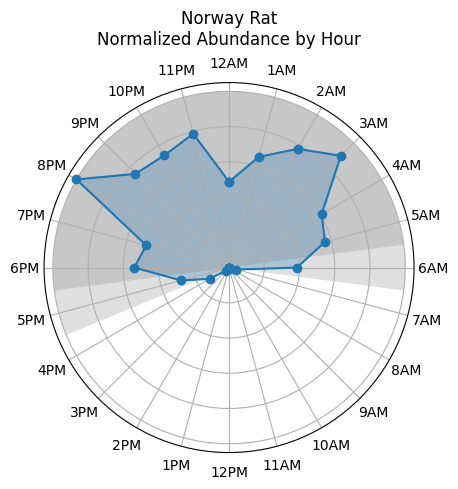

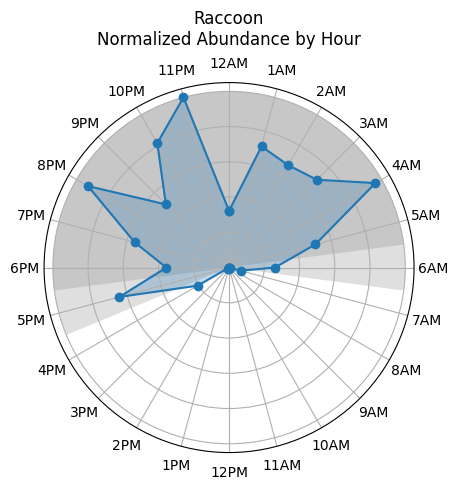

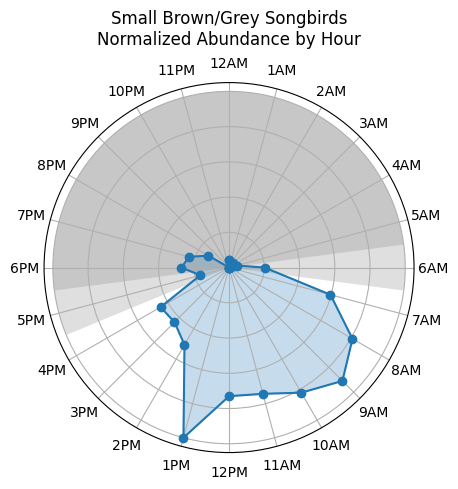

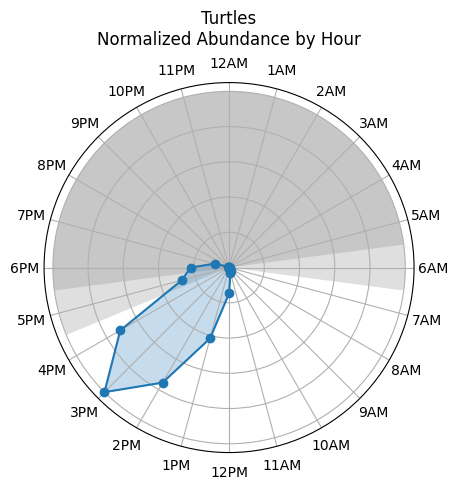

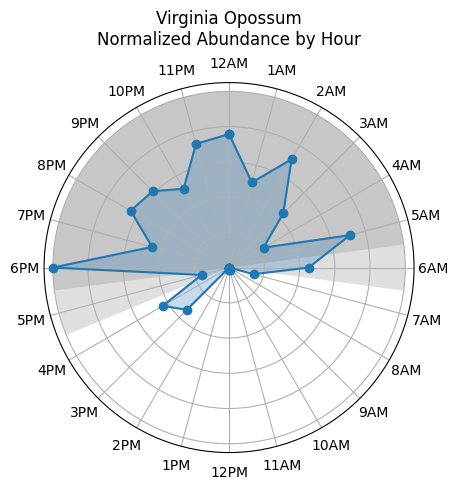

In [39]:
species_list = species_hour_counts['common_name'].unique()
hours = np.arange(24)
angles = np.deg2rad(hours * (360 / 24))  # map 0–23 to radians (0–2π)
hour_labels = [f"{h%12 if h%12 else 12}{'AM' if h < 12 else 'PM'}" for h in hours]

for species in species_list:
    data = species_hour_counts[species_hour_counts['common_name'] == species]
    data = data.set_index('hour').reindex(hours, fill_value=0).reset_index()
    
    values = data['norm_count'].values
    values = np.append(values, values[0])            # close the loop
    angles_full = np.append(angles, angles[0])

    # Create plot
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, polar=True)

    # Rotate so 12 AM is at the top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Shade night time: from 5 PM (17) to 5 AM (5)
    night_hours = list(range(17, 24)) + list(range(0, 6))
    for h in night_hours:
        theta1 = (h / 24.0) * 360
        theta2 = ((h + 1) / 24.0) * 360
        ax.bar(
            x=np.deg2rad(np.linspace(theta1, theta2, 2)),
            height=[1, 1],
            width=np.deg2rad(theta2 - theta1),
            bottom=0,
            color='gray',
            alpha=0.25,
            edgecolor=None
        )

    # Plot the data
    ax.plot(angles_full, values, marker='o', color='tab:blue')
    ax.fill(angles_full, values, color='tab:blue', alpha=0.25)

    # Format ticks
    ax.set_xticks(angles)
    ax.set_xticklabels(hour_labels)
    ax.set_yticklabels([])  # hide radial labels

    ax.set_title(f"{species}\nNormalized Abundance by Hour", va='bottom')
    plt.tight_layout()
    plt.show()